In [1]:
#set up

import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np

import cv2
from skimage import morphology

import os

In [2]:
folder = './input'
files = os.listdir(folder)
files.remove('.DS_Store')
box_filepath = [os.path.join(folder, file) for file in files]
box_filepath.sort()
video = [imread(image) for image in box_filepath]

video[0].shape, len(video)

((320, 240), 22)

1


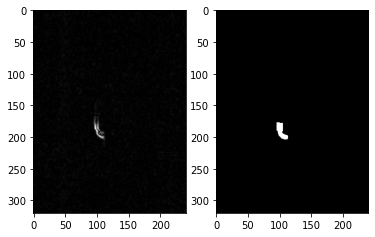

2


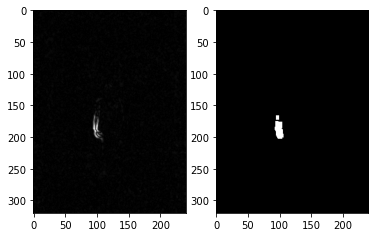

3


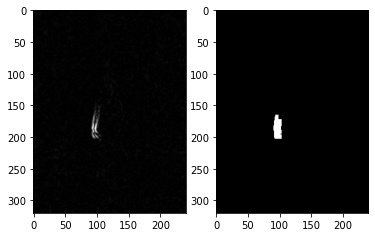

4


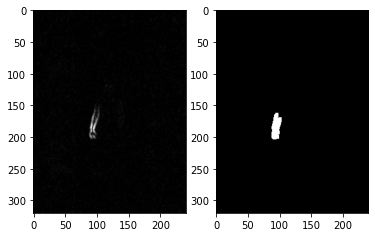

5


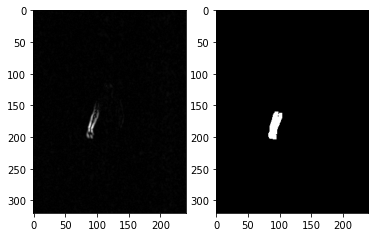

6


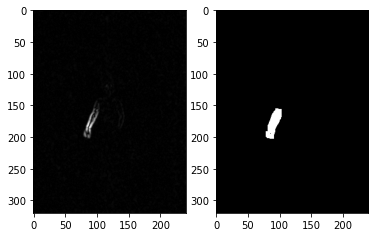

7


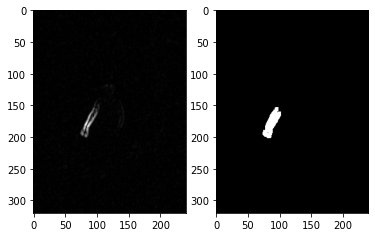

8


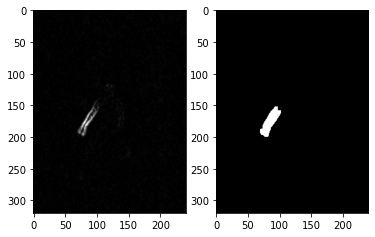

9


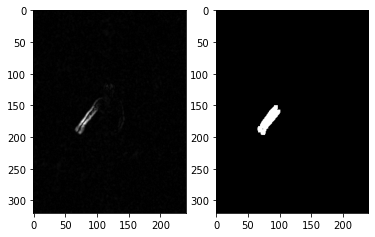

10


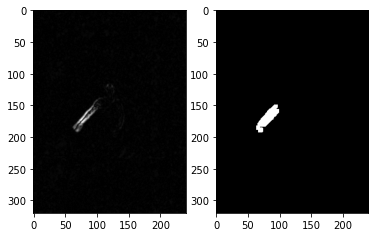

11


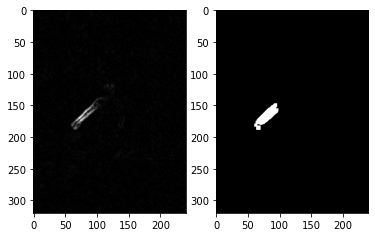

12


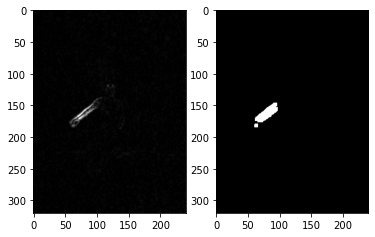

13


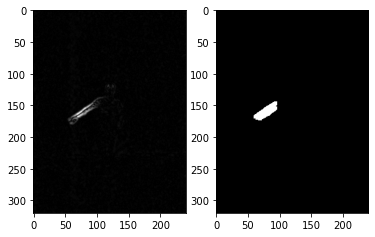

14


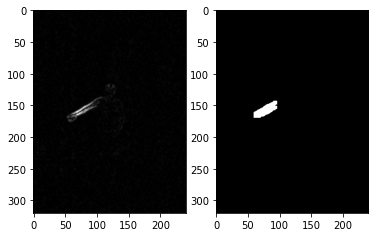

15


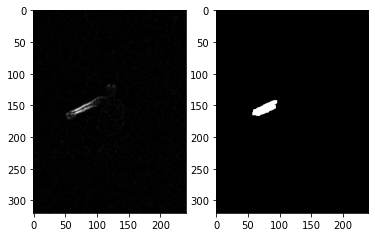

16


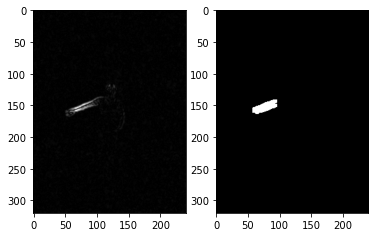

17


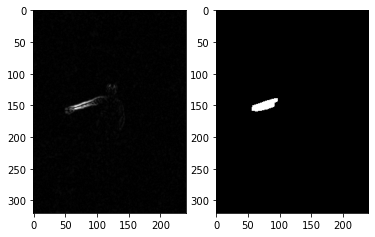

18


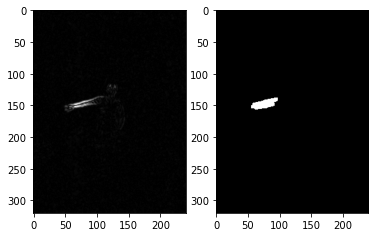

19


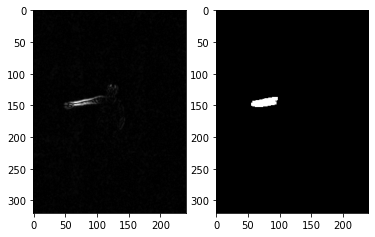

20


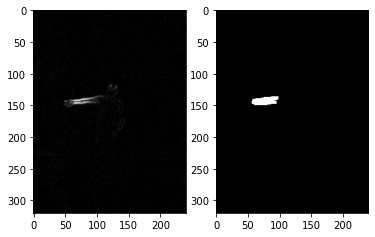

21


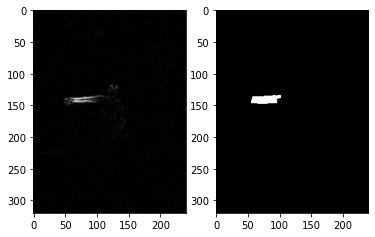

In [3]:
boxes = [cv2.GaussianBlur(image, (5, 5), 0) for image in video]

for i in range(len(boxes)):
   
    if i == 0:
        continue
    print(i)
    
    # Difference frame
    diff = cv2.absdiff(boxes[i], boxes[i-1])
    
    # Threshold & Dilate
    movement = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]
    movement = cv2.dilate(movement, None, iterations = 2) 
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(diff, cmap='gray')
    ax2.imshow(movement, cmap='gray') 
    plt.show()

In [4]:
def updateMotionHistory(motion_diff, motion_history, timestamp, duration):
    
    mhi = np.array(motion_history)
    h, w = motion_diff.shape
    
    for i in range(h):
        for j in range(w):
            
            if motion_diff[i,j] != 0:
                mhi[i,j] = timestamp
            elif mhi[i,j] < timestamp - duration:
                mhi[i,j] = 0

#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.imshow(motion_diff, cmap='gray')
#     ax2.imshow(mhi, cmap='gray') 
#     plt.show()
    
    return mhi

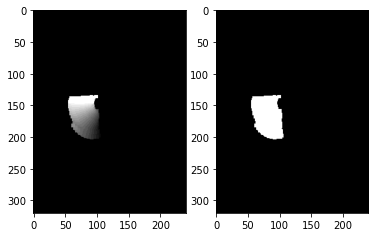

In [5]:
motion_history = np.zeros_like(boxes[0], np.float32)

for i in range(len(boxes)):
   
    if i == 0:
        previous = np.zeros_like(boxes[0])
        continue
    
    # Difference frame
    diff = cv2.absdiff(boxes[i], boxes[i-1])
    
    # Threshold & Dilate
    movement = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]
    movement = cv2.dilate(movement, None, iterations = 2)
    
    # MHI
    motion_history = updateMotionHistory(movement, motion_history, i, 22)
    
motion_history_image = np.clip((motion_history - 1) / (21), 0, 1)
motion_energy_image = cv2.threshold(motion_history_image, 0, 1, cv2.THRESH_BINARY)[1]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(motion_history_image, cmap='gray')
ax2.imshow(motion_energy_image, cmap='gray') 
plt.show()

In [6]:
def moment(X, p=0, q=0):
    assert isinstance(X, np.ndarray), "`X` should be an ndarray"
    
    # Initiate x, y indexes for summation
    x_idx = np.arange(X.shape[1])
    y_idx = np.arange(X.shape[0])
    
    # Compute the first three moments
    m_00 = np.sum(X)
    m_10 = np.sum(X @ x_idx)
    m_01 = np.sum(y_idx @ X)
    
    if p == 0 and q == 0:
        return m_00
    elif p == 1 and q == 0:
        return m_10
    elif p == 0 and q == 1:
        return m_01
    
    # Compute the centroids
    x_bar = m_10 / m_00
    y_bar = m_01 / m_00
    
    # Compute other central moments
    m_pq = (y_idx - y_bar)**q @ X @ (x_idx - x_bar)**p
    
    # Compute similitude moment
    power = (p + q) / 2 + 1
    moment = m_pq / m_00**power
    
    return moment

def similitude_moments(X):
    assert isinstance(X, np.ndarray), "`X` should be an ndarray"
    
    N = [moment(X, p=0, q=2),
         moment(X, p=0, q=3),
         moment(X, p=1, q=1),
         moment(X, p=1, q=2),
         moment(X, p=2, q=0),
         moment(X, p=2, q=1),
         moment(X, p=3, q=0),
        ]
    
    return N

In [7]:
m_mhi = similitude_moments(motion_history_image)
m_mei = similitude_moments(motion_energy_image)

m_mhi, m_mei

([0.1879526719373596,
  0.048301193589052854,
  0.011044497521862517,
  0.011669092238614212,
  0.09315570943372868,
  -0.0035263130070673377,
  0.0018390968289134885],
 [0.1266915373360526,
  0.0020863984922236717,
  0.023260510864008873,
  0.0037997125413986115,
  0.05877995400790563,
  -0.0009752419307690133,
  -0.0013982715109285009])